# Query Expansion

## Installation

Expansion with generated answers. Use an LLM to suggest an answer to the question that cna help provide relavant context. In this example we are going to create a template that takes the role of a financial investor. Although the answer is hypotehtical, in otherwords we want the LLM to hallucinate. However, the question/answer from the LLM can help better guide the vector retrival. 

In [1]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Connecting to the vector database

In [2]:
import chromadb
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

In [3]:
chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

Number of items in the collection 'microsoft_annual_report_2022': 349


## The embedding function

In [4]:
# Access the underlying SentenceTransformer model (Defaults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


## Helper to print the retrieved documents

In [5]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')

## Setting up the LLM

In [16]:
from openai import OpenAI
openai_client = OpenAI()

## Visualizing the documents

In [17]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
  0%|          | 0/349 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprec

## Expansion with generated answers
## Hypothetical answer
https://arxiv.org/abs/2305.03653

What we are doing here is creating a query with a hypotehtical answer. In otherwords we are asking gpt without a RAG (pure speculation)

In [8]:
def augment_query_generated(query, model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [15]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print("joint query:", joint_query)
print(word_wrap(joint_query))

joint query: Was there significant turnover in the executive team? Yes, during the fiscal year 2023, our company experienced significant turnover in the executive team. Specifically, we welcomed two new executives: John Smith was appointed as Chief Financial Officer in March 2023, bringing over 15 years of financial leadership experience, and Lisa Brown joined as Chief Marketing Officer in July 2023, leveraging her extensive background in digital marketing and brand strategy.

Additionally, we saw the departure of two key executives: the former Chief Operating Officer, Rachel Adams, left the organization in January 2023 to pursue other opportunities, and the Chief Technology Officer, Michael Lee, departed in May 2023 for personal reasons.

These changes were part of our strategic initiative to enhance operational efficiency and drive innovation forward. The board is committed to ensuring a smooth transition and stability within the leadership team as we continue to focus on achieving o

What they did here is purposly create an LLM hallucination that we can use to enhance the query.

This is used to just create the joint_query

## Find the top 5 results from the vector Database

Now we are using the joint query against the RAG.

In [19]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['343', '324', '344', '125', '190']

embeddings:
  Item 1: [[-0.00488765 -0.08827505  0.01002432 ... -0.15240112  0.08323981
  -0.03052867]
 [-0.0058015  -0.00989232  0.00184315 ... -0.01929419  0.0399938
  -0.06140678]
 [ 0.0393805  -0.01059783 -0.01434924 ... -0.11655344  0.0762848
  -0.0024916 ]
 [-0.01207692  0.01987469  0.03173836 ... -0.04308904 -0.02074122
   0.03627496]
 [-0.03464141 -0.05439477 -0.02035364 ... -0.0328651   0.07708184
  -0.02178704]]

documents:
  Item 1: ['89 directors and executive officers of microsoft corporation directors satya nadella chairman and chief executive officer, microsoft corporation sandra e. peterson 2, 3 operating partner, clayton, dubilier & rice, llc john w. stanton 1, 4 founder and chairman, trilogy partnerships reid g. hoffman 4 general partner, greylock partners penny s. pritzker 4 founder and chairman, psp partners, llc john w. thompson 3, 4 lead independent director, microsoft corporation hugh f. johnston 1 vice chairman

We have three sets of embedding:

retrieved embeddings from the RAG 
original query 
joint query (answer and hypothetical)

In [20]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

## Visualize the results

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

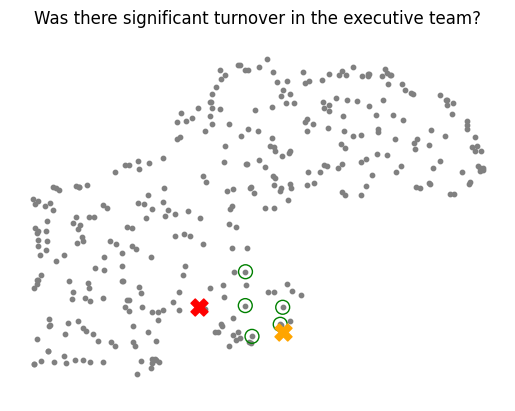

In [21]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Red is original query, Orange is augmented , green is retrived.

What we see is that we moved the original query in vector space (orange) and better aligns wit the retrived answers.

## Expansion with multiple queries

Use an LLM to generate good questions to search through your embeddings.  
The system prompt is more detailed this time.   
You should experiment with differnt prompts.   


In [22]:
def augment_multiple_query(query, model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [23]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the revenue figures for the previous year?  
How did market trends impact revenue growth?  
What role did new product launches play in revenue increases?  
Were there any significant changes in pricing strategy?  
How did customer demographics affect revenue performance?  


We have the LLM augment our questions (more and better)

In [ ]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents (if we get same results multiple times)

unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

What do we get in geometric spcae.

In [25]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/v

In [27]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


  0%|          | 0/30 [00:00<?, ?it/s]/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/johnwillis/.pyenv/versions/3.11.9/lib/python3.11/site-p

(0.7186514556407928, 10.606608587503434, 7.177721071243286, 14.084149312973022)

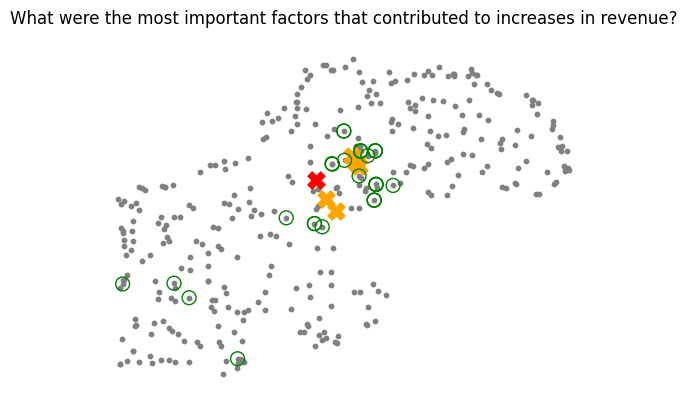

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

We see we able to hit other parts of the vector we might not have been able to reach with this query expansion technique.   
A single query only hits one point in an embedding space. Multiple queries (questions) hits more areas of the emedding space.   
Gives us a better change of getting beter/more results. 

The downside is that we might have too much results.


Food for thought:   
Play around with different queries (i.e. prompts and results).
